In [ ]:
!pip install lmfit
!pip install tikzplotlib
%matplotlib inline
import numpy as np

import pandas as pd 
pd.__version__
from lmfit import models, Parameters, Model
import matplotlib.pyplot as plt
# Use the seborn style
#plt.style.use('seaborn')
import tikzplotlib
import re
def clean_string(string):
  return re.sub('[^A-Za-z0-9]+','', string )

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [148]:
#results=pd.DataFrame(columns=('amplitude','amplitude stderr','center','center stderr','sigma','sigma stderr','fwhm','fwhm stderr','height','height stderr','chi squared'))
results=pd.DataFrame(columns=('rm','rm stderr','sigma','sigma stderr','ra','ra stderr','chi squared'))
start=0
end=max_x
x_sim=np.linspace(start,end,300)
def rock(x, rm, sigma):
    #return amp/(x*sigma*np.sqrt(2*np.pi))*np.exp((np.log(x/rm))**2/(2*sigma))
    #return amp/(x*sigma*np.sqrt(2*np.pi))*np.exp(-(np.log(x/rm))**2/(2*sigma))
    return 1.0/(np.sqrt(2*np.pi)*x*sigma)*np.exp(-(np.log(x/rm))**2/(2*sigma**2))

fits=dict()
#https://lmfit.github.io/lmfit-py/builtin_models.html#lognormalmodel
title="fitting log normal distribution"
for key, value in datatofit.items():
  x=value['center']
  y=value['norm']
  fit=pd.DataFrame(columns=('x','y','dely'))
  model = Model(rock)
  #params = model.make_params(sigma=3.0, rm=1.0)
  params = Parameters()
  #params.add('amp', value=1.0, min=1E-10, max=1E6, vary=False)
  params.add('sigma', value=0.5, min=1E-10, max=1.0,vary=True)
  params.add('rm', value=3.0, min=0.5,max=100, vary=True)

  result = model.fit(y, params, x=x)
  print(result.fit_report())
  plt.title(title)
  plt.bar(x, y, width=bin_width, alpha=0.5,align='center',label=key)
  
  #plt.plot(x, result.best_fit, label=key+'-fit')
  fit['x']=x_sim
  fit['y']=model.eval(x=x_sim, params=result.params)
  fit['dely'] = result.eval_uncertainty(x=x_sim)
  plt.plot(fit['x'], fit['y'], label=key+'-eval')
  results.at[key,'chi squared']=result.chisqr
  results.at[key,'R squared']=result.rsquared
  # results.at[key,'amplitude']=result.params['amp'].value
  # results.at[key,'amplitude stderr']=result.params['amp'].stderr
  results.at[key,'rm']=result.params['rm'].value
  results.at[key,'rm stderr']=result.params['rm'].stderr
  results.at[key,'sigma']=result.params['sigma'].value
  results.at[key,'sigma stderr']=result.params['sigma'].stderr
  results.at[key,'ra']=result.params['rm'].value*np.exp((result.params['sigma'].value**2)/2)
  results.at[key,'ra stderr']=result.params['rm'].stderr*np.exp((result.params['sigma'].value**2)/2)
  fits[key]=fit
  
plt.legend()
plt.show()
#tikzplotlib.save("{}.tex".format(title.replace(' ','_')))
results.to_csv('log_fit.csv')

./190c_1000h_1iteration.csv
./190c_2500h_1iteration.csv
./log_fit.csv
./T61_1iteration.csv
./190C_250h_min_size.csv


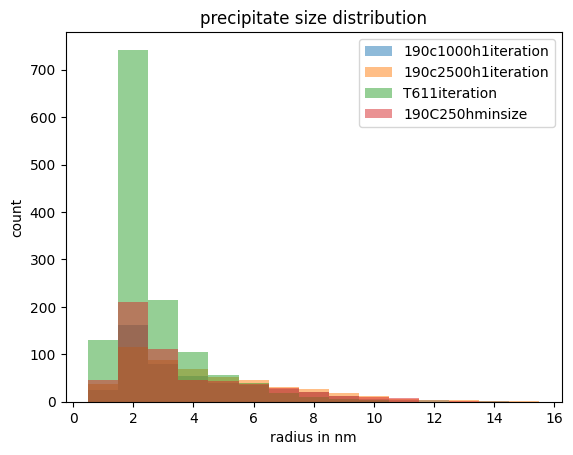

In [150]:
#plot all histograms
title='precipitate size distribution'
plt.figure()
for key, value in datatofit.items():
  plt.bar(value['center'], value['count'], width=bin_width, alpha=0.5,align='center',label=key)
  # plt.plot(value[col_label_x],value[col_label_y],label=key)
  plt.title(title)
  plt.xlabel(plot_x_label)
  plt.ylabel('count')
  plt.legend()
plt.show()
  #tikzplotlib.save("{}.tex".format(title.replace(' ','_')))

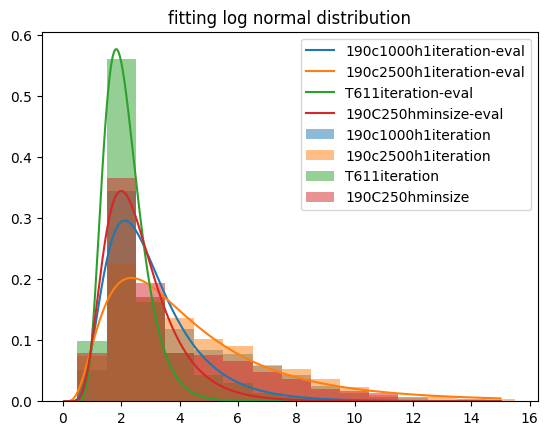

In [155]:
#results=pd.DataFrame(columns=('amplitude','amplitude stderr','center','center stderr','sigma','sigma stderr','fwhm','fwhm stderr','height','height stderr','chi squared'))
results=pd.DataFrame(columns=('amplitude','amplitude stderr','rm','rm stderr','sigma','sigma stderr','ra','ra stderr','chi squared'))
start=0
end=max_x
x_sim=np.linspace(start,end,300)
def rock(x, amp, rm, sigma):
    #return amp/(x*sigma*np.sqrt(2*np.pi))*np.exp((np.log(x/rm))**2/(2*sigma))
    return amp/(x*sigma*np.sqrt(2*np.pi))*np.exp(-(np.log(x/rm))**2/(2*sigma))

fits=dict()
#https://lmfit.github.io/lmfit-py/builtin_models.html#lognormalmodel
title="fitting log normal distribution"
for key, value in datatofit.items():
  x=value['center']
  y=value['norm']
  fit=pd.DataFrame(columns=('x','y','dely'))
  model = Model(rock)
  #params = model.make_params(sigma=3.0, rm=1.0)
  params = Parameters()
  params.add('amp', value=1.0, min=1E-10, max=1E6, vary=True)
  params.add('sigma', value=0.5, min=1E-10, max=1.0,vary=True)
  params.add('rm', value=3.0, min=0.5,max=100, vary=True)

  result = model.fit(y, params, x=x)
  #print(result.fit_report())
  plt.title(title)
  plt.bar(x, y, width=bin_width, alpha=0.5,align='center',label=key)
  
  #plt.plot(x, result.best_fit, label=key+'-fit')
  fit['x']=x_sim
  fit['y']=model.eval(x=x_sim, params=result.params)
  fit['dely'] = result.eval_uncertainty(x=x_sim)
  plt.plot(fit['x'], fit['y'], label=key+'-eval')
  results.at[key,'chi squared']=result.chisqr
  results.at[key,'amplitude']=result.params['amp'].value
  results.at[key,'amplitude stderr']=result.params['amp'].stderr
  results.at[key,'rm']=result.params['rm'].value
  results.at[key,'rm stderr']=result.params['rm'].stderr
  results.at[key,'sigma']=result.params['sigma'].value
  results.at[key,'sigma stderr']=result.params['sigma'].stderr
  results.at[key,'ra']=result.params['rm'].value*np.exp((result.params['sigma'].value**2)/2)
  results.at[key,'ra stderr']=result.params['rm'].stderr*np.exp((result.params['sigma'].value**2)/2)
  fits[key]=fit
  
plt.legend()
plt.show()
#tikzplotlib.save("{}.tex".format(title.replace(' ','_')))
results.to_csv('log_fit.csv')


In [156]:
results

,amplitude,amplitude stderr,rm,rm stderr,sigma,sigma stderr,ra,ra stderr,chi squared
190c1000h1iteration,0.422761,0.078177,2.69544,0.173923,0.238177,0.04922,2.772989,0.178927,0.013943
190c2500h1iteration,0.684326,0.062518,3.714598,0.162463,0.457322,0.045974,4.124077,0.180372,0.002157
T611iteration,0.297706,0.022208,2.03596,0.044113,0.106685,0.008344,2.047579,0.044365,0.005148
190C250hminsize,0.360032,0.051325,2.416258,0.111706,0.189737,0.02985,2.460145,0.113735,0.00995


190c1000h1iteration Index(['center', 'count', 'norm'], dtype='object')
190c2500h1iteration Index(['center', 'count', 'norm'], dtype='object')
T611iteration Index(['center', 'count', 'norm'], dtype='object')
190C250hminsize Index(['center', 'count', 'norm'], dtype='object')


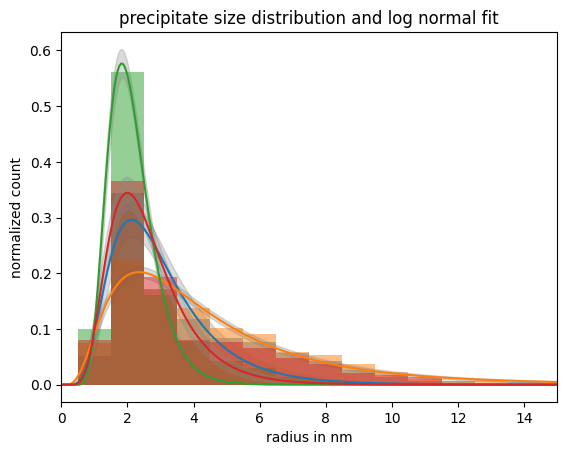

In [159]:
# plot all histograms and fitted lognormal distributions
model =models.LognormalModel()
title='precipitate size distribution and log normal fit'
for key, value in datatofit.items():
  print(key,value.columns) #width=bin_width, alpha=0.5, 
  plt.bar(value['center'], value['norm'], width=bin_width, alpha=0.5,align='center',label=key)
  # plt.plot(value[col_label_x],value[col_label_y],label=key)
  plt.title(title)
  plt.xlabel(plot_x_label)
  plt.ylabel(plot_y_label)
  plt.plot(fits[key]['x'], fits[key]['y'],label=key+'-fit')
  plt.fill_between(fits[key]['x'], fits[key]['y']-fits[key]['dely'],
                fits[key]['y']+fits[key]['dely'], color='#888888',alpha=0.3)
  plt.xlim([0.0, max_x])
  #plt.legend()
  tikzplotlib.save("{}.tex".format(title.replace(' ','_')))


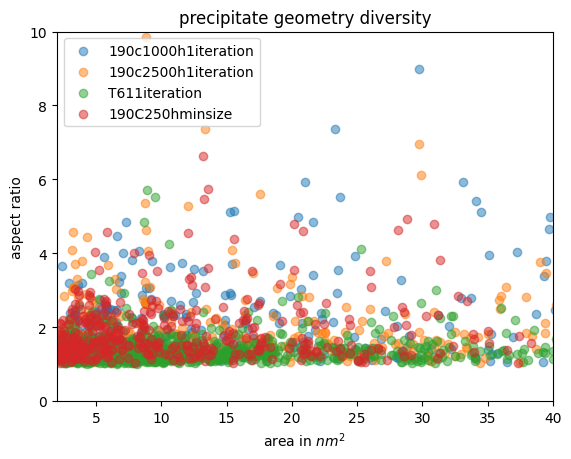

In [160]:
#visualize geometry diversity
title='precipitate geometry diversity'
for key, value in data.items():
  plt.scatter(x=data[key]['area_in_nm2'],y=data[key]['aspect_ratio'], alpha=0.5, label=key)
  plt.title(title)
  plt.xlabel(r'area in $nm^2$')
  plt.ylabel('aspect ratio')
  plt.xlim([2,40])
  plt.ylim([0,10])
plt.legend()
plt.show()  
#tikzplotlib.save("{}.tex".format(title.replace(' ','_')))
